In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl', context='notebook', ticks=True, grid=False, figsize=(10,6))

In [2]:
from glob import glob
import os
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from datetime import datetime
from collections import OrderedDict, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary as summary_
import torchvision
import torchvision.transforms as transforms

import data_loader
import utils
import calibration
import train as t

import calibration
uniform_calib_mean = calibration.CalibrationLoss()
uniform_calib_max = calibration.CalibrationLoss(func='max')
quantile_calib_mean = calibration.CalibrationLoss(strategy='quantile')
quantile_calib_max = calibration.CalibrationLoss(strategy='quantile', func='max')

In [3]:
testloader = data_loader.get_test_loader(
                    data_dir='./data',
                    batch_size=32,
                    shuffle=False,
                    num_workers=4,
                    pin_memory=False,
                )

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified


In [4]:
def load_model(modelname, model_path) : 
    model = torch.hub.load('pytorch/vision:v0.10.0', modelname, pretrained=True)
    hidden_size = model.fc.weight.shape[1]
    model.fc = nn.Linear(hidden_size, len(utils.label_names))

    state_dict = torch.load(model_path)
    adj_state_dict = OrderedDict()
    for k,v in state_dict.items() : 
        adj_state_dict[k.replace("module.",'')] = v

    model.load_state_dict(adj_state_dict)
    model = model.eval().to(device)
    return model

def inference(testloader, device, model, criterion) : 
    umean_container = list()
    umax_container = list()
    qmean_container = list()
    qmax_container = list()
    loss_container = list()
    acc_container = list()

    for inputs, labels in tqdm(testloader) :

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        predictions = outputs.argmax(1)
        acc = (outputs.argmax(1).eq(labels).sum() / outputs.shape[0]).item()

        loss = criterion(outputs, labels)

        loss_container.append(loss.item())
        acc_container.append(acc)

        prob, true = torch.softmax(outputs, dim=1).cpu().data.numpy(), labels.cpu().data.numpy()

        ece = uniform_calib_mean.calculate_ce(prob, true)
        umean_container.append(ece)

        ece = uniform_calib_max.calculate_ce(prob, true)
        umax_container.append(ece)

        ece = quantile_calib_mean.calculate_ce(prob, true)
        qmean_container.append(ece)

        ece = quantile_calib_max.calculate_ce(prob, true)
        qmax_container.append(ece)

    test_loss = np.mean(loss_container)
    test_acc = np.mean(acc_container)
    test_umean = np.mean(umean_container)
    test_umax = np.mean(umax_container)
    test_qmean = np.mean(qmean_container)
    test_qmax = np.mean(qmax_container)
    
    return test_loss, test_acc, test_umean, test_umax, test_qmean, test_qmax

In [5]:
modelname_iter = map(lambda x : os.path.basename(x).split("_")[0].split(".")[0], glob('models/*'))
data = list(zip(modelname_iter, glob("models/*")))

In [6]:
container = defaultdict(list)

for modelname, path in data : 
    model = load_model(modelname, path)
    test_loss, test_acc, test_umean, test_umax, test_qmean, test_qmax = inference(testloader, device, model, criterion)
    container['log loss'].append(test_loss)
    container['accuracy'].append(test_acc)
    container['umean'].append(test_umean)
    container['umax'].append(test_umax)
    container['qmean'].append(test_qmean)
    container['qmax'].append(test_qmax)

Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


/home/hfcp/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


In [7]:
def inference(testloader, device, model, criterion) : 
    prob_container, true_container = list(), list()
    model.eval()
    for inputs, labels in testloader :

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        predictions = outputs.argmax(1)
        acc = (outputs.argmax(1).eq(labels).sum() / outputs.shape[0]).item()

        loss = criterion(outputs, labels)

        prob, true = torch.softmax(outputs, dim=1).cpu().data.numpy(), labels.cpu().data.numpy()

        prob_container.append(prob)
        true_container.append(true)
        
    return np.concatenate(prob_container), np.concatenate(true_container)

In [8]:
prob, true = inference(testloader, device, model, criterion)

sigmoid_calibrator = pd.read_pickle('./sigmoid_calibrator.pickle')

calibrated_prob = sigmoid_calibrator.predict_proba(prob)
calibrated_perf = [
    calibration.log_loss(true, calibrated_prob),
    (calibrated_prob.argmax(1) == true).sum() / true.shape[0],
    uniform_calib_mean.calculate_ce(calibrated_prob, true),
    uniform_calib_max.calculate_ce(calibrated_prob, true),
    quantile_calib_mean.calculate_ce(calibrated_prob, true),
    quantile_calib_max.calculate_ce(calibrated_prob, true)]

In [9]:
colname = list(map(lambda x : os.path.splitext(os.path.basename(x[1]))[0].split(".")[0], data))
df = pd.DataFrame.from_dict(container, orient='index', columns=colname)
df['resnet18_sigmoid_scaling'] = calibrated_perf
df

,resnet18_focal,resnet152,resnet18_mixup,resnet18_label_smoothing,resnet18_erl,resnet18_ls,resnet18,resnet18_sigmoid_scaling
log loss,0.538523,0.605172,0.401981,0.616175,0.560470,0.594764,0.614018,0.627382
accuracy,0.834165,0.790635,0.888079,0.815196,0.822584,0.872105,0.813199,0.819500
umean,0.204310,0.201665,0.142814,0.206545,0.183276,0.186663,0.207988,0.102282
umax,0.468148,0.482278,0.338602,0.462192,0.444875,0.363929,0.459594,0.251964
qmean,0.034004,0.035752,0.024827,0.041809,0.028831,0.046049,0.042499,0.010542
qmax,0.198920,0.216736,0.150018,0.214721,0.197265,0.195764,0.209470,0.059785


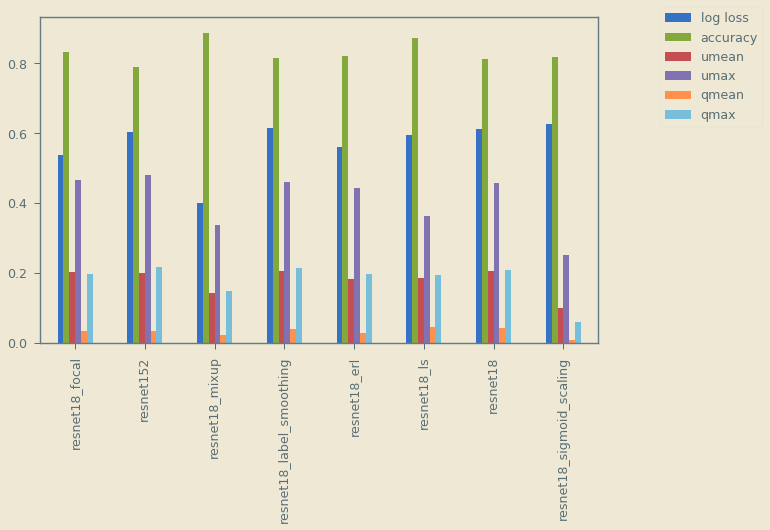

In [10]:
df.T.plot.bar(figsize=(10,6))
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [11]:
best_performer = dict(zip(df.index, df.columns[np.argmin(df.values, axis=1)]))
del best_performer['accuracy']
best_performer

{'log loss': 'resnet18_mixup',
 'umean': 'resnet18_sigmoid_scaling',
 'umax': 'resnet18_sigmoid_scaling',
 'qmean': 'resnet18_sigmoid_scaling',
 'qmax': 'resnet18_sigmoid_scaling'}

In [12]:
worst_performer = dict(zip(df.index, df.columns[np.argmax(df.values, axis=1)]))
del worst_performer['accuracy']
worst_performer

{'log loss': 'resnet18_sigmoid_scaling',
 'umean': 'resnet18',
 'umax': 'resnet152',
 'qmean': 'resnet18_ls',
 'qmax': 'resnet152'}